# Master Drifter Evaluation Notebook

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

### Skill score definition

[Liu and Weisberg 2011, JGR Oceans](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010JC006837)

$$\left. s = \sum_{i=1}^Nd_i \middle/ \sum_{i=1}^NI_{oi} \right.$$

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


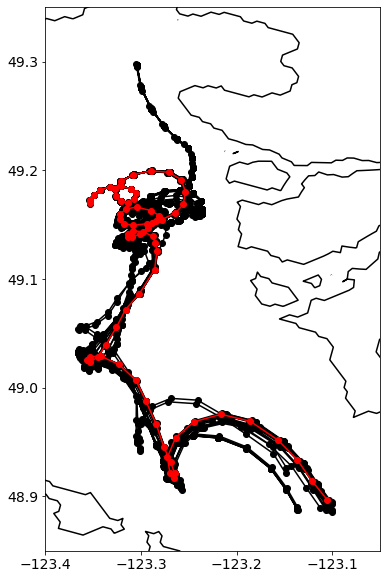

In [9]:
# Paths, files and definitions
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
fn = '/data/bmoorema/results/parcels/drifters_base/drifter003_20160418_20160423.nc'
deg2m = 111000 * np.cos(50 * np.pi / 180)
index = 30

# Make figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-123.4, -123.05])
ax.set_ylim([48.85, 49.35])
viz_tools.set_aspect(ax)

# Load simulation
with xr.open_dataset(fn) as data:
    
    # Load and plot trajectories
    lons, lats = data.lon.values[:, :72], data.lat.values[:, :72]
    for lon, lat in zip(lons, lats): ax.plot(lon, lat, 'ko-')
    ax.plot(lons[index, :], lats[index, :], 'ro-')

    # Separation distance
    d = np.sqrt((lons - lons[index, :])**2 + (lats - lats[index, :])**2) * deg2m * 1e-3

    # Travelled distance
    dl = np.sqrt((lons[index, 1:] - lons[index, :-1])**2 + (lons[index, 1:] - lons[index, :-1])**2) * deg2m * 1e-3
    dl = np.insert(dl, 0, 0)
    
    SS = np.cumsum(d, axis=1) / np.cumsum(np.cumsum(dl))

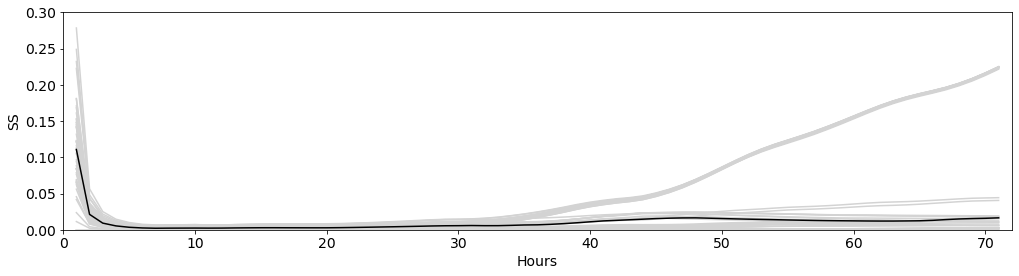

In [13]:
fig, ax = plt.subplots(figsize=(17, 4))
ax.set_xlim([0, 72])
ax.set_ylim([0, 0.3])
ax.set_xlabel('Hours')
ax.set_ylabel('SS')
for ss in SS: ax.plot(ss, color='lightgray')
ax.plot(np.median(SS, axis=0), 'k-')